In [48]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import fbeta_score, make_scorer
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import optuna

data.dtypes
df=pd.DataFrame(data)


target='Attrition'
X= df.drop(columns=[target, 'EmpID'], axis=1)
y= df[target]

from sklearn.preprocessing import OneHotEncoder


# one-hot encoding
encoder=OneHotEncoder(sparse_output=False)
categorical_columns=X.select_dtypes(include=['object']).columns.tolist()
one_hot_encoded=encoder.fit_transform(X[categorical_columns])
one_hot_df=pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))

# Concatenate the one-hot encoded dataframe with the original dataframe
X_encoded = pd.concat([X, one_hot_df], axis=1)

# Drop the original categorical columns
# After one-hot encoding and before scaling
X_encoded = pd.concat([X, one_hot_df], axis=1)
X_encoded = X_encoded.drop(categorical_columns, axis=1)

# Combine X and y into a single dataframe
combined_df = pd.concat([X_encoded, y], axis=1)

# Drop NaN values from the combined dataframe
combined_df = combined_df.dropna()

# Split back into X and y
X = combined_df.drop(columns=[target])
y = combined_df[target]

# Continue with your mapping of y
y = y.map({'Yes': 1, 'No': 0})


from sklearn.preprocessing import StandardScaler
# Now proceed with scaling
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Scale features
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X_resampled)

# Split data
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y_resampled, test_size=0.2, random_state=42)

# Define Optuna objective
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.5, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 10)
    }
    
    model = xgb.XGBClassifier(**params, random_state=42)
    
    # Use cross-validation score
    score = cross_val_score(model, X_train, y_train, cv=5, scoring=make_scorer(fbeta_score, beta=2))
    return score.mean()

# Create and run Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Get best parameters and train final model
best_params = study.best_params
best_model = xgb.XGBClassifier(**best_params, random_state=42)
best_model.fit(X_train, y_train)

from sklearn.metrics import roc_curve

# Get predicted probabilities
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Calculate ROC curve and find optimal threshold
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
J = tpr - fpr
optimal_idx = np.argmax(J)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal threshold: {optimal_threshold}")

# Make predictions using the optimal threshold
y_pred = (y_pred_proba >= optimal_threshold).astype(int)

# Evaluate the model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

[I 2024-07-15 13:37:36,217] A new study created in memory with name: no-name-68d9932d-0cef-4937-b61d-da3e4a7876b5
[I 2024-07-15 13:37:36,473] Trial 0 finished with value: 0.8902292225945567 and parameters: {'max_depth': 1, 'learning_rate': 0.3472667927794636, 'n_estimators': 184, 'min_child_weight': 5, 'subsample': 0.5197177373756714, 'colsample_bytree': 0.5967648321751072, 'gamma': 0.007531804984232664, 'scale_pos_weight': 6.5113941033802165}. Best is trial 0 with value: 0.8902292225945567.
[I 2024-07-15 13:37:37,474] Trial 1 finished with value: 0.8752980036197338 and parameters: {'max_depth': 2, 'learning_rate': 0.18230743545865147, 'n_estimators': 742, 'min_child_weight': 1, 'subsample': 0.9727413051981207, 'colsample_bytree': 0.7202901303644195, 'gamma': 1.1586086736348022e-05, 'scale_pos_weight': 2.3077318804626428}. Best is trial 0 with value: 0.8902292225945567.
[I 2024-07-15 13:37:37,845] Trial 2 finished with value: 0.8433799685258583 and parameters: {'max_depth': 3, 'learnin

Optimal threshold: 0.7096168398857117
Accuracy: 0.9347826086956522

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.97      0.94       226
           1       0.97      0.90      0.93       234

    accuracy                           0.93       460
   macro avg       0.94      0.94      0.93       460
weighted avg       0.94      0.93      0.93       460


Confusion Matrix:
[[220   6]
 [ 24 210]]


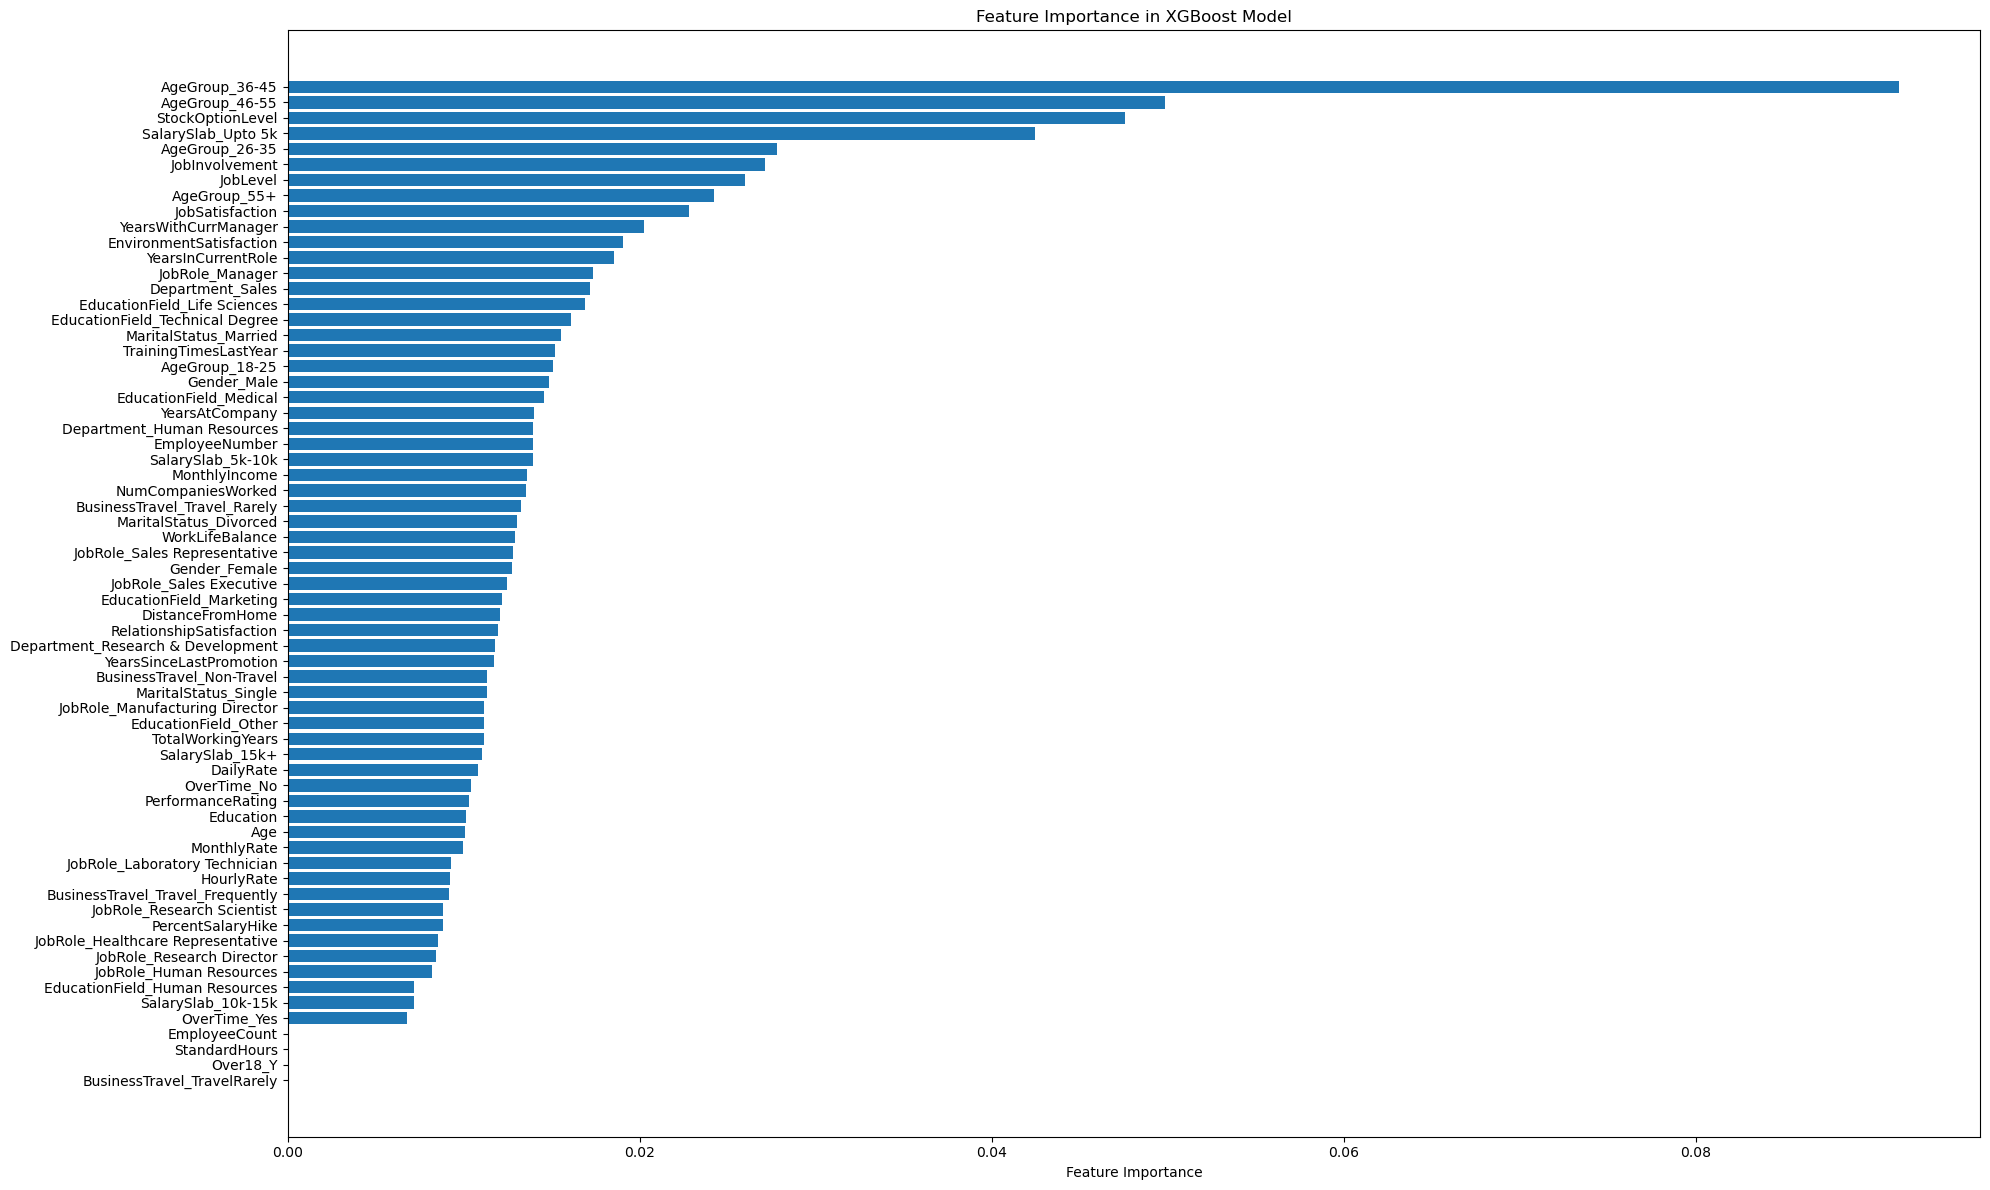

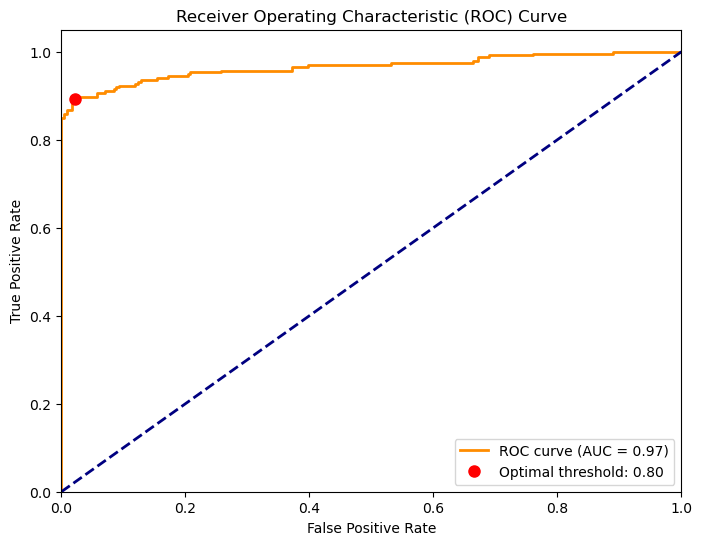

Top 10 Important Features:
                 feature  importance
28        AgeGroup_36-45    0.091564
29        AgeGroup_46-55    0.049830
18      StockOptionLevel    0.047547
61    SalarySlab_Upto 5k    0.042433
27        AgeGroup_26-35    0.027814
8         JobInvolvement    0.027128
9               JobLevel    0.025989
30          AgeGroup_55+    0.024208
10       JobSatisfaction    0.022804
25  YearsWithCurrManager    0.020228


In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

# Feature Importance Plot
plt.figure(figsize=(20,12))
feature_importance = best_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Feature Importance in XGBoost Model')
plt.tight_layout()
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Plot the optimal threshold point
optimal_idx = np.argmax(tpr - fpr)
plt.plot(fpr[optimal_idx], tpr[optimal_idx], 'ro', markersize=8, 
         label=f'Optimal threshold: {thresholds[optimal_idx]:.2f}')
plt.legend()

plt.show()

# Print top 10 important features
feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 10 Important Features:")
print(feature_importance_df.head(10))

In [40]:
# Create a results dataframe
results_df = pd.DataFrame({
    'Actual_Attrition': y_test,
    'Attrition_Probability': y_pred_proba,
    'Predicted_Attrition': y_pred
})

# Show top 10 at-risk employees
print("\nTop 10 employees at risk of attrition:")
at_risk = results_df.sort_values('Attrition_Probability', ascending=False).head(10)
print(at_risk)

# Calculate summary statistics
print("\nSummary:")
print(f"Total employees: {len(results_df)}")
print(f"Predicted attrition: {results_df['Predicted_Attrition'].sum()} ({results_df['Predicted_Attrition'].mean():.2%})")


Top 10 employees at risk of attrition:
      Actual_Attrition  Attrition_Probability  Predicted_Attrition
1604                 1               0.982641                    1
2051                 1               0.982065                    1
2198                 1               0.981439                    1
2196                 1               0.981387                    1
2203                 1               0.980884                    1
1376                 1               0.980781                    1
1748                 1               0.980719                    1
1983                 1               0.980709                    1
1831                 1               0.980584                    1
2167                 1               0.980452                    1

Summary:
Total employees: 460
Predicted attrition: 214 (46.52%)


In [41]:
# Get feature names
feature_names = X.columns.tolist()

print("Features used for prediction:")
for i, feature in enumerate(feature_names, 1):
    print(f"{i}. {feature}")

# Save feature names for later use
import joblib
joblib.dump(feature_names, 'feature_names.joblib')


Features used for prediction:
1. Age
2. DailyRate
3. DistanceFromHome
4. Education
5. EmployeeCount
6. EmployeeNumber
7. EnvironmentSatisfaction
8. HourlyRate
9. JobInvolvement
10. JobLevel
11. JobSatisfaction
12. MonthlyIncome
13. MonthlyRate
14. NumCompaniesWorked
15. PercentSalaryHike
16. PerformanceRating
17. RelationshipSatisfaction
18. StandardHours
19. StockOptionLevel
20. TotalWorkingYears
21. TrainingTimesLastYear
22. WorkLifeBalance
23. YearsAtCompany
24. YearsInCurrentRole
25. YearsSinceLastPromotion
26. YearsWithCurrManager
27. AgeGroup_18-25
28. AgeGroup_26-35
29. AgeGroup_36-45
30. AgeGroup_46-55
31. AgeGroup_55+
32. BusinessTravel_Non-Travel
33. BusinessTravel_TravelRarely
34. BusinessTravel_Travel_Frequently
35. BusinessTravel_Travel_Rarely
36. Department_Human Resources
37. Department_Research & Development
38. Department_Sales
39. EducationField_Human Resources
40. EducationField_Life Sciences
41. EducationField_Marketing
42. EducationField_Medical
43. EducationField_

['feature_names.joblib']

In [42]:
def manual_prediction(model, scaler, feature_names, threshold):
    # Create a dictionary to store user inputs
    user_input = {}
    
    # Ask for input for each feature
    for feature in feature_names:
        value = input(f"Enter value for {feature}: ")
        # Convert to float if possible, otherwise keep as string
        try:
            user_input[feature] = float(value)
        except ValueError:
            user_input[feature] = value
    
    # Convert user input to DataFrame
    input_df = pd.DataFrame([user_input])
    
    # Ensure all columns from original feature set are present
    for col in feature_names:
        if col not in input_df.columns:
            input_df[col] = 0  # or another appropriate default value
    
    # Reorder columns to match original feature order
    input_df = input_df[feature_names]
    
    # Scale the input
    scaled_input = scaler.transform(input_df)
    
    # Make prediction
    probability = model.predict_proba(scaled_input)[0, 1]
    prediction = 1 if probability >= threshold else 0
    
    return probability, prediction

# Example usage:
# probability, prediction = manual_prediction(best_model, scaler, feature_names, optimal_threshold)
# print(f"Attrition Probability: {probability:.4f}")
# print(f"Prediction: {'Attrition' if prediction == 1 else 'No Attrition'}")

In [43]:
import joblib

joblib.dump(best_model, 'best_model.joblib')
joblib.dump(scaler, 'scaler.joblib')
joblib.dump(optimal_threshold, 'optimal_threshold.joblib')

['optimal_threshold.joblib']

In [46]:
import pandas as pd
import numpy as np
import joblib

# Load saved components
loaded_model = joblib.load('best_model.joblib')
loaded_scaler = joblib.load('scaler.joblib')
loaded_threshold = joblib.load('optimal_threshold.joblib')
feature_names = joblib.load('feature_names.joblib')  # Load the feature names

# Define core features and their types (as before)
core_features = {
    'Age': 'numeric',
    'DailyRate': 'numeric',
    'DistanceFromHome': 'numeric',
    'Education': 'numeric',
    'EnvironmentSatisfaction': 'numeric',
    'JobInvolvement': 'numeric',
    'JobLevel': 'numeric',
    'JobSatisfaction': 'numeric',
    'MonthlyIncome': 'numeric',
    'NumCompaniesWorked': 'numeric',
    'StockOptionLevel': 'numeric',
    'TotalWorkingYears': 'numeric',
    'YearsAtCompany': 'numeric',
    'YearsInCurrentRole': 'numeric',
    'YearsSinceLastPromotion': 'numeric',
    'YearsWithCurrManager': 'numeric',
    'BusinessTravel': 'categorical',
    'Department': 'categorical',
    'EducationField': 'categorical',
    'Gender': 'categorical',
    'JobRole': 'categorical',
    'MaritalStatus': 'categorical',
    'OverTime': 'categorical'
}

def get_user_input(features):
    user_input = {}
    for feature, feature_type in features.items():
        if feature_type == 'numeric':
            value = float(input(f"Enter value for {feature}: "))
        else:
            value = input(f"Enter value for {feature}: ")
        user_input[feature] = value
    return user_input

def encode_categorical(input_data):
    return pd.get_dummies(pd.DataFrame([input_data]), columns=[k for k, v in core_features.items() if v == 'categorical'])

def manual_prediction(model, scaler, threshold, feature_names):
    user_input = get_user_input(core_features)
    input_df = encode_categorical(user_input)
    
    # Ensure all necessary columns are present
    for col in feature_names:
        if col not in input_df.columns:
            input_df[col] = 0
    
    # Reorder columns to match the model's expected input
    input_df = input_df[feature_names]
    
    # Scale the input
    scaled_input = scaler.transform(input_df)
    
    # Make prediction
    probability = model.predict_proba(scaled_input)[0, 1]
    prediction = 1 if probability >= threshold else 0
    
    return probability, prediction

# Make a prediction
probability, prediction = manual_prediction(loaded_model, loaded_scaler, loaded_threshold, feature_names)
print(f"Attrition Probability: {probability:.4f}")
print(f"Prediction: {'Attrition' if prediction == 1 else 'No Attrition'}")

# After training the model
joblib.dump(X.columns.tolist(), 'feature_names.joblib')

Enter value for Age:  45
Enter value for DailyRate:  450
Enter value for DistanceFromHome:  16
Enter value for Education:  2
Enter value for EnvironmentSatisfaction:  3
Enter value for JobInvolvement:  2
Enter value for JobLevel:  1
Enter value for JobSatisfaction:  1
Enter value for MonthlyIncome:  450
Enter value for NumCompaniesWorked:  1
Enter value for StockOptionLevel:  0
Enter value for TotalWorkingYears:  1
Enter value for YearsAtCompany:  1
Enter value for YearsInCurrentRole:  1
Enter value for YearsSinceLastPromotion:  0
Enter value for YearsWithCurrManager:  1
Enter value for BusinessTravel:  Travel_Rarely
Enter value for Department:  Sales
Enter value for EducationField:  Marketing
Enter value for Gender:  Male
Enter value for JobRole:  Sales Representative
Enter value for MaritalStatus:  Married
Enter value for OverTime:  Yes


Attrition Probability: 0.9235
Prediction: Attrition


['feature_names.joblib']